In [9]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [10]:
def benchmark(X, Y):
    return -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)


In [11]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [12]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [13]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-4.5, 4.5, 5)
Y = np.random.uniform(-4.5, 4.5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [14]:
df

x         y            z
0 -0.746802 -3.668953 -1695.133401
1  1.982920 -2.823658 -2231.461373
2 -4.498971 -1.389953  -522.757847
3 -1.779007 -0.929093   -64.660164
4 -3.179197  0.349351   -70.191649

In [15]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [16]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32360766 -2.98273191]


In [17]:
df_sim = df.copy()

df_sim

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

In [18]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

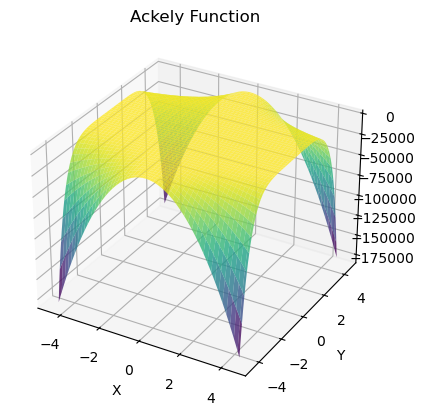

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackely Function')

# Show the plot
plt.show()

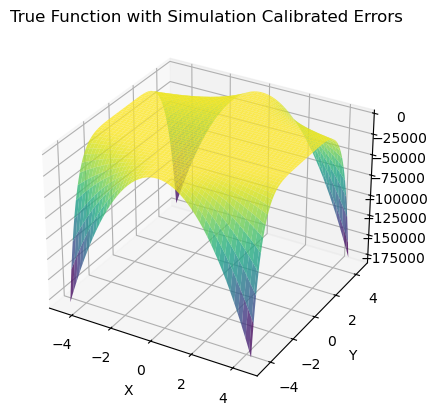

In [20]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [21]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [22]:
df_new = pd.DataFrame

In [23]:
obj_val_df = pd.DataFrame(columns=["Highest_Sim_Response", "Num_Points_In_df"])

In [24]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=200, batch_size=128, verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-4.5, 4.5, 100)
    x2_range = np.linspace(-4.5, 4.5, 100)
    bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    global obj_val_df
    # Append to tracking DataFrame
    new_entry = pd.DataFrame({
        "Highest_Sim_Response": [df2['sim_z'].max()],
        "Num_Points_In_df": [len(df)]
    })
    obj_val_df = pd.concat([obj_val_df, new_entry], ignore_index=True)

    return df, df2


Best hyperparameters:
num_layers: 10
num_units: 182
learning_rate: 0.00015519747234775592
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1626262.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1626242.8750
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1626223.3750
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1626202.1250
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1626180.5000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1626156.6250
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1626129.6250
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1626099.5000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1626065.8750
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1626028.5000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1625986.1250
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1625937.8750
Epoch 13/200

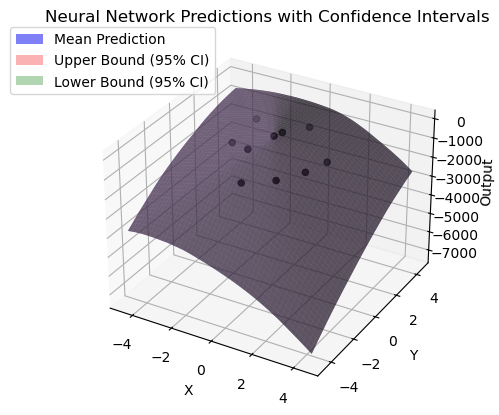

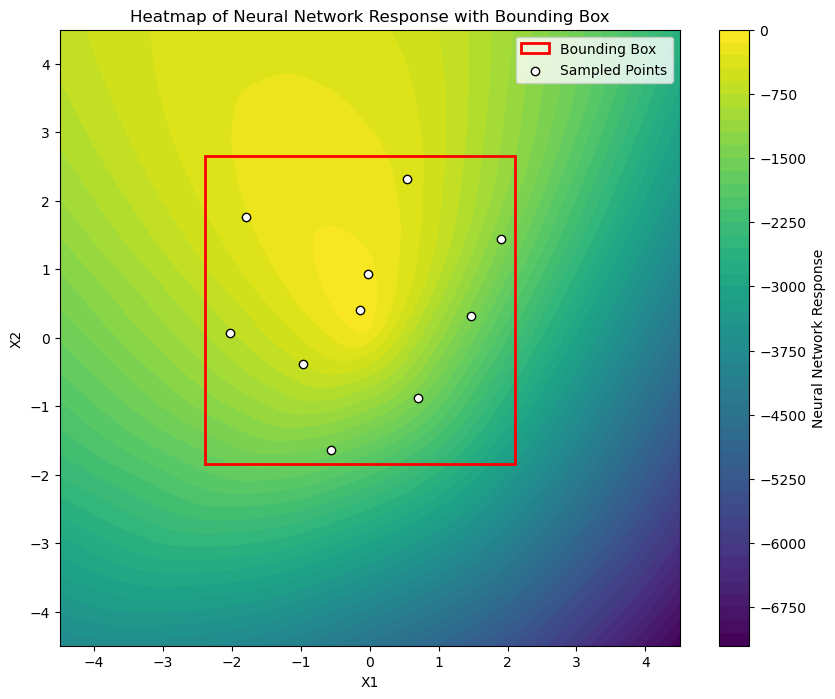

          x         y          z         a         b      sim_z      diff
2  1.462440  0.311197  -2.668165  4.323608 -2.982732  -2.494803 -0.173362
8  0.705514 -0.880646  -6.460696  4.323608 -2.982732  -6.460676 -0.000020
6 -0.029818  0.937577 -14.205088  4.323608 -2.982732 -14.247343  0.042255
9 -0.136364  0.409091 -15.708284  4.323608 -2.982732 -15.657951 -0.050333
1 -0.971008 -0.383384 -30.897646  4.323608 -2.982732 -30.901777  0.004131
           x         y            z         a         b        sim_z      diff
0  -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1   1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2  -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3  -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4  -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
5   0.539692  2.315737  -103.345202  4.323608 -2.982732  -103.239173 -0.106029
6  

In [25]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.03200677745000151
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step - loss: 543602.4375
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 542061.1250
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 540133.5000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 537349.7500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 533313.4375
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 527709.5625
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 520279.2188
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 510744.3438
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 498811.5312
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 484226.9375
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 466573.8438
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 445860.1875
Epoch 13/200
1/1 ━━━━━━━━━

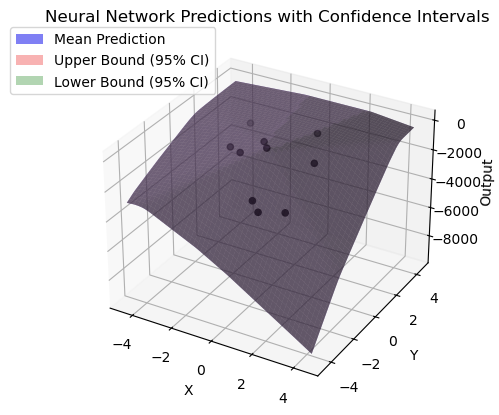

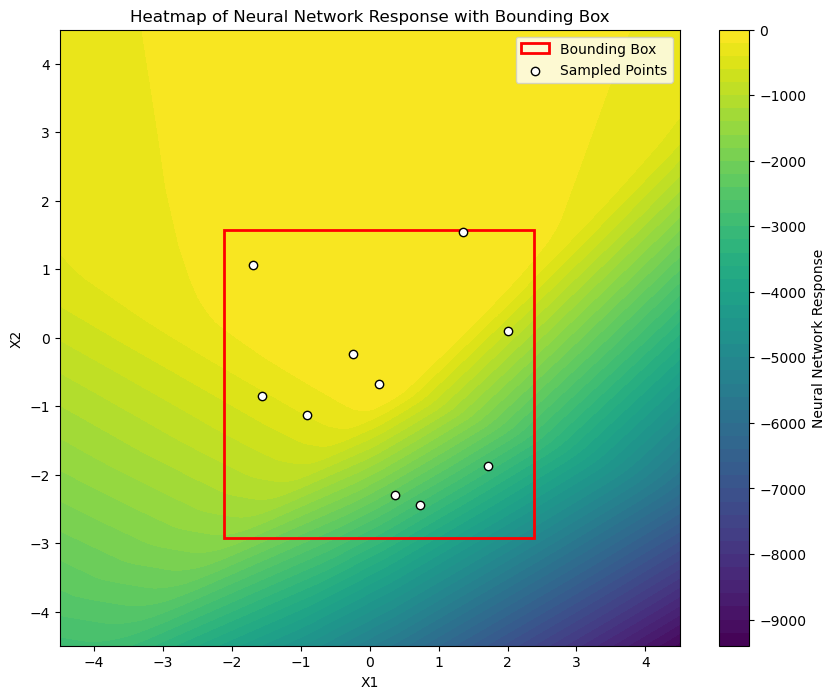

In [26]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.003127914271485729
dropout_rate: 0.0
batch_size: 96
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 328060.9375
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 327793.5312
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 327400.1875
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 326756.3125
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 325711.2188
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 324087.1875
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 321655.1250
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 318132.6250
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 313188.8438
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 306485.2812
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 297674.8125
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 286485.8125
Epoch 13/200
1/1 ━━━━━━━━━━

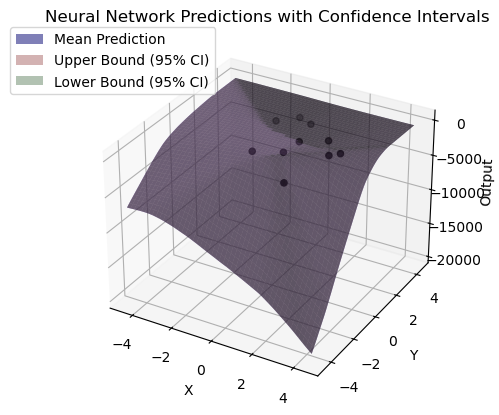

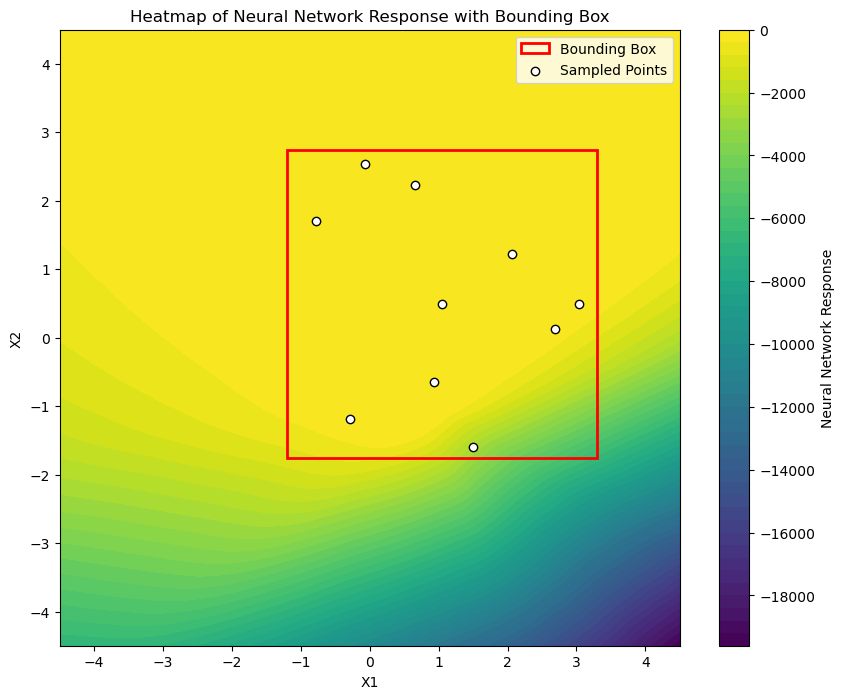

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 187
learning_rate: 0.0012259033506353087
dropout_rate: 0.44631216178931804
batch_size: 83
epochs: 50
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 234729.7812
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 234682.5156
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 234648.6562
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 234600.6562
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 234502.4375
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 234347.5469
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 234385.2969
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 234205.7656
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 234253.0156
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 233965.8281
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 233658.9375
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 233403.3594
Epoch 13/20

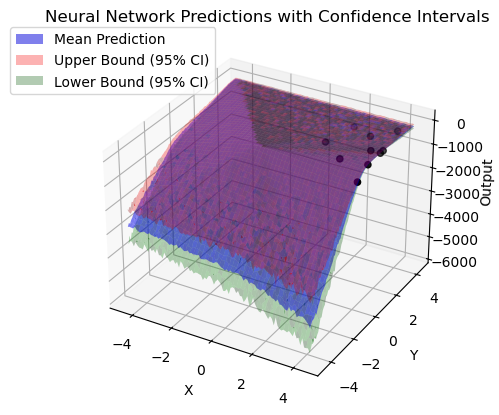

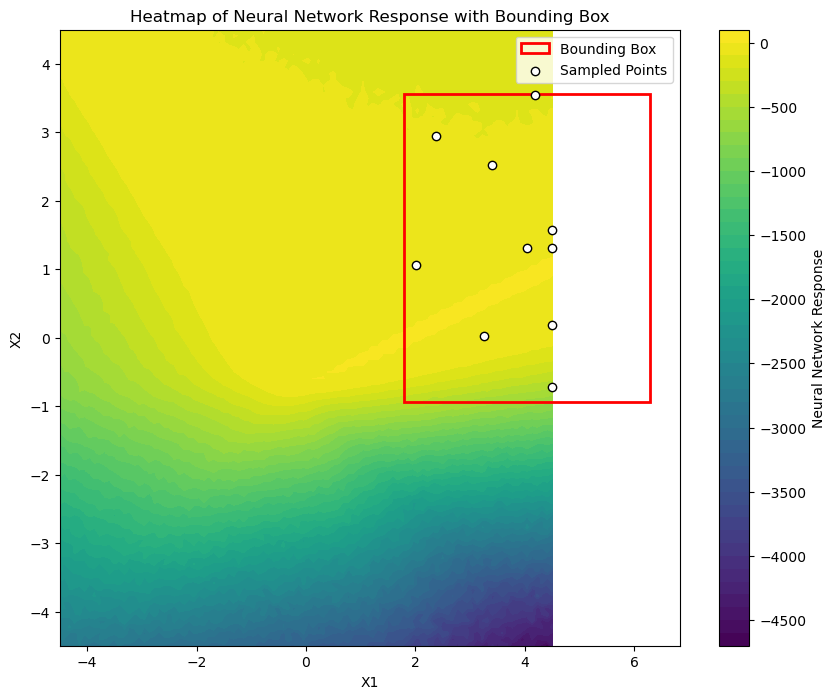

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.0026111360994137216
dropout_rate: 0.0
batch_size: 150
epochs: 137
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 31631056.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31629728.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 31627592.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 31623826.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 31617416.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 31606638.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 31588818.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 31560744.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31516946.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 31450778.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 31352712.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 31211424.0000
E

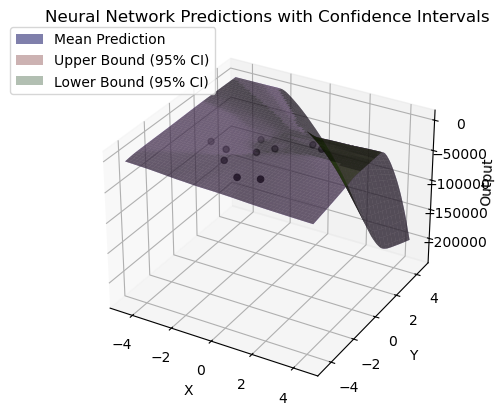

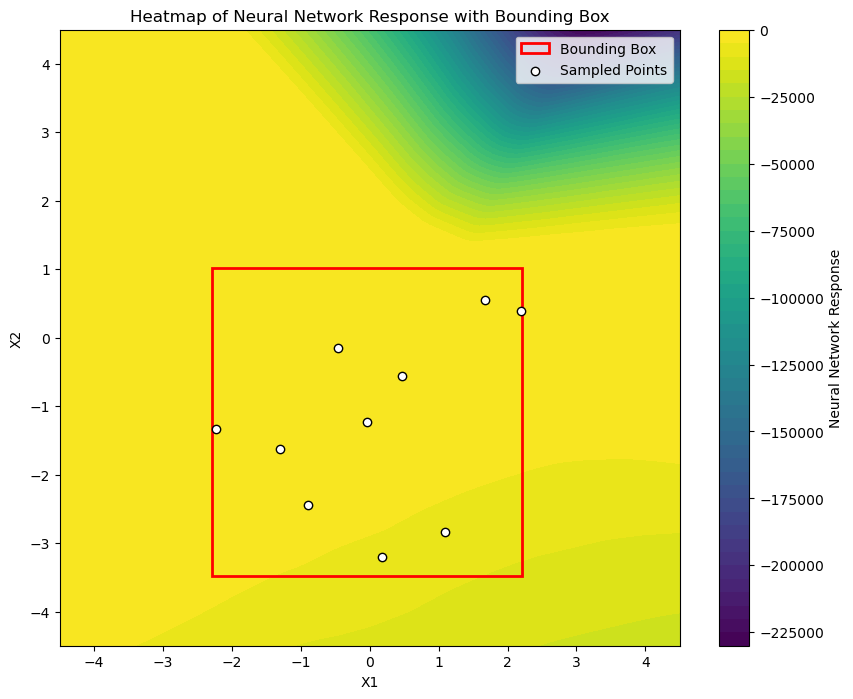

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.0021362697577789803
dropout_rate: 0.3662563241130049
batch_size: 79
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 25889954.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25888636.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25888310.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25887108.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25884806.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25883866.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 25882860.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 25875816.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25870346.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25861370.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25864864.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2

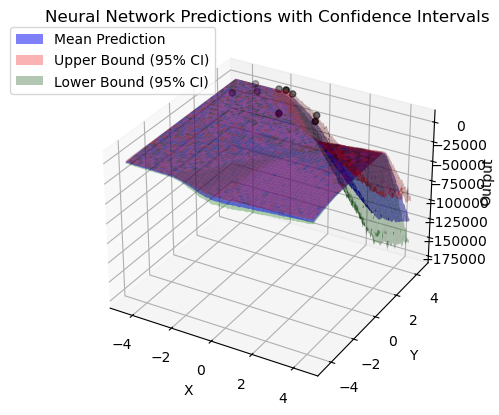

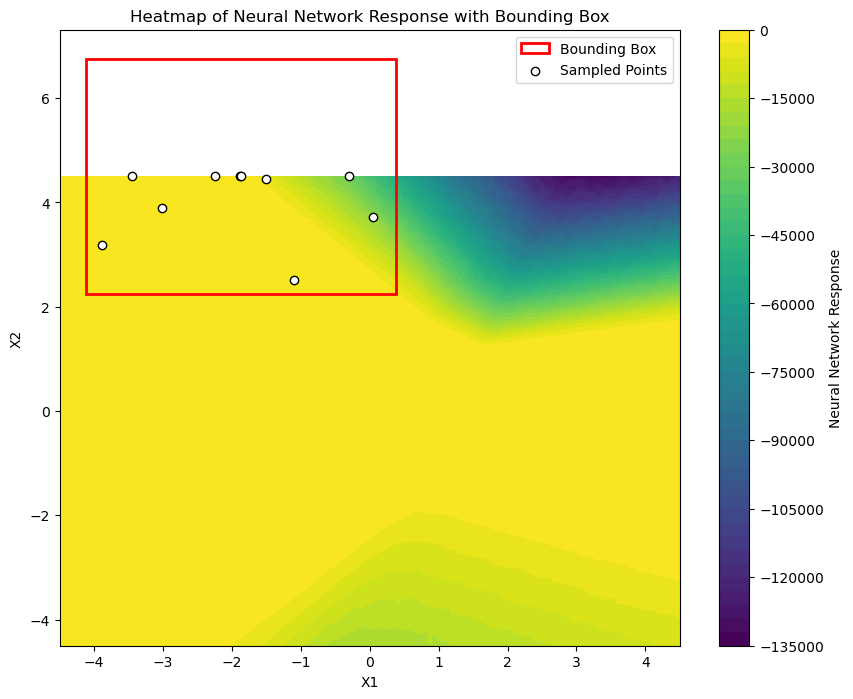

          x         y             z         a         b         sim_z  \
2  0.049631  3.719028    -37.238243  4.323608 -2.982732    -37.299225   
5 -1.094215  2.505475   -194.401301  4.323608 -2.982732   -194.561575   
4 -0.307530  4.500000   -643.100497  4.323608 -2.982732   -643.261469   
1 -3.883579  3.188008 -15398.260809  4.323608 -2.982732 -15398.820442   
0 -1.511233  4.450255 -17354.646121  4.323608 -2.982732 -17354.842364   

       diff  
2  0.060981  
5  0.160273  
4  0.160972  
1  0.559632  
0  0.196243  
           x         y             z         a         b         sim_z  \
0  -0.746802 -3.668953  -1695.133401  4.323608 -2.982732  -1694.266005   
1   1.982920 -2.823658  -2231.461373  4.323608 -2.982732  -2231.474423   
2  -4.498971 -1.389953   -522.757847  4.323608 -2.982732   -521.819231   
3  -1.779007 -0.929093    -64.660164  4.323608 -2.982732    -64.195661   
4  -3.179197  0.349351    -70.191649  4.323608 -2.982732    -69.863205   
..       ...       ...           

In [30]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

In [31]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

KeyboardInterrupt: 

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 215897104.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 215878112.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 215795760.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 215490912.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 214661312.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 212833264.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 209179072.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 200295120.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 189977248.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 173931072.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 166630304.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 188368992.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 182613712.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/ste

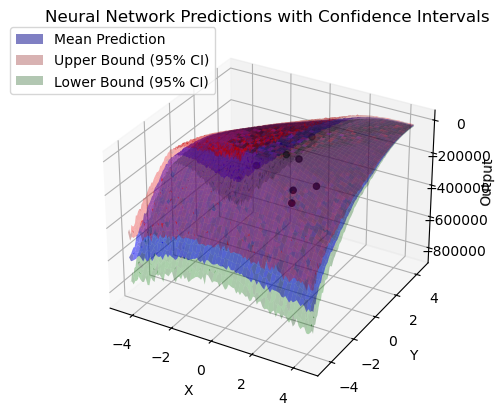

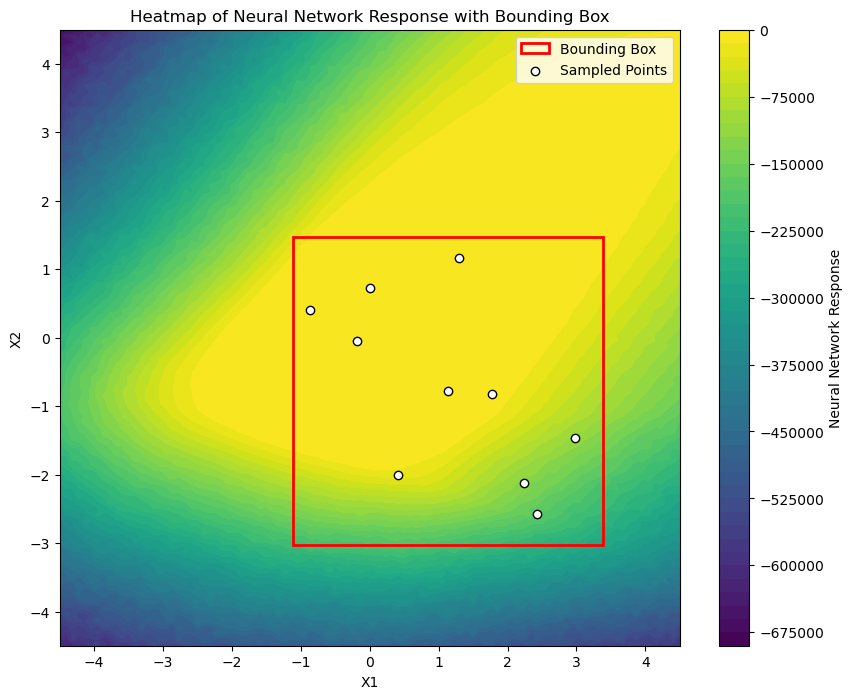

In [78]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 190548816.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 190524240.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 190413744.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 190084912.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 189122336.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 186859648.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 182198400.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 173060464.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 163182816.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 154353840.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 155347168.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 157104224.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 155238288.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste

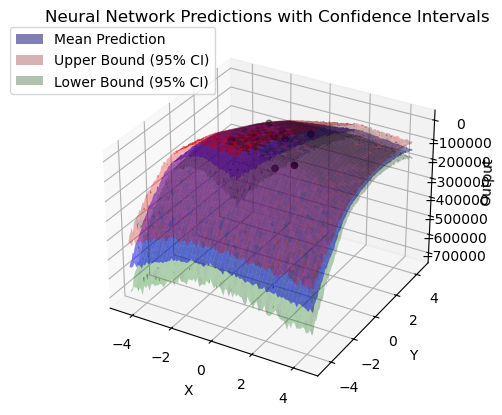

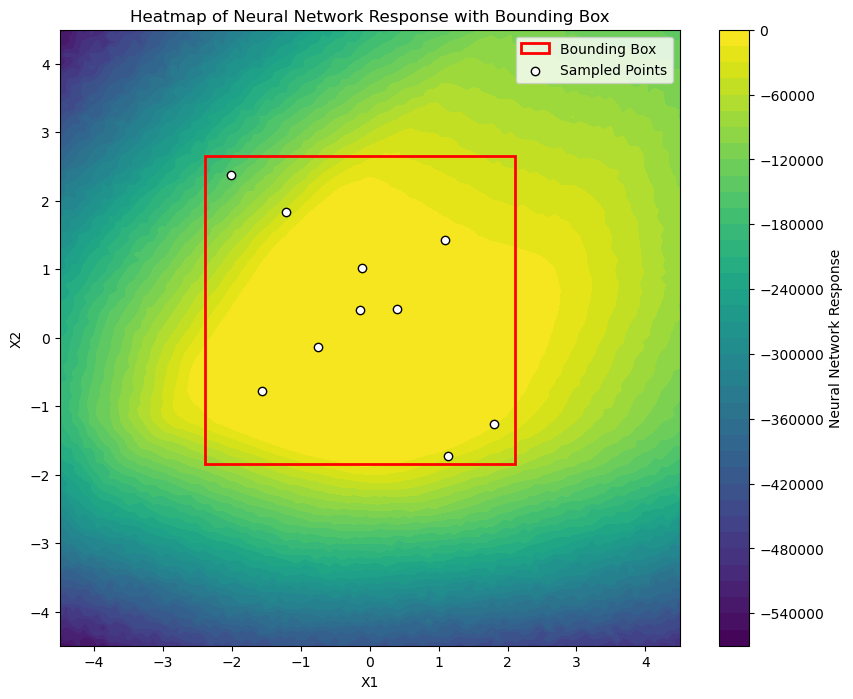

In [79]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 170495344.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 170478656.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 170416224.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 170187136.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 169490576.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 168055152.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 164884944.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 159519648.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 149179872.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 139744496.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 140334896.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 144140432.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 147657664.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

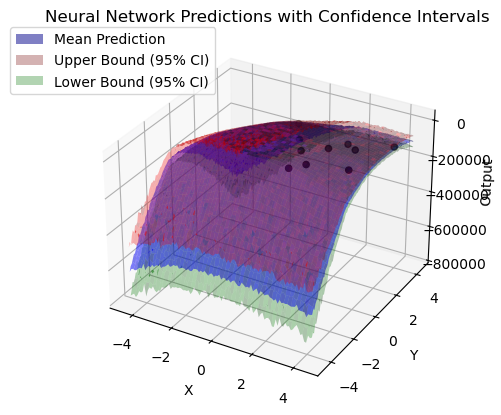

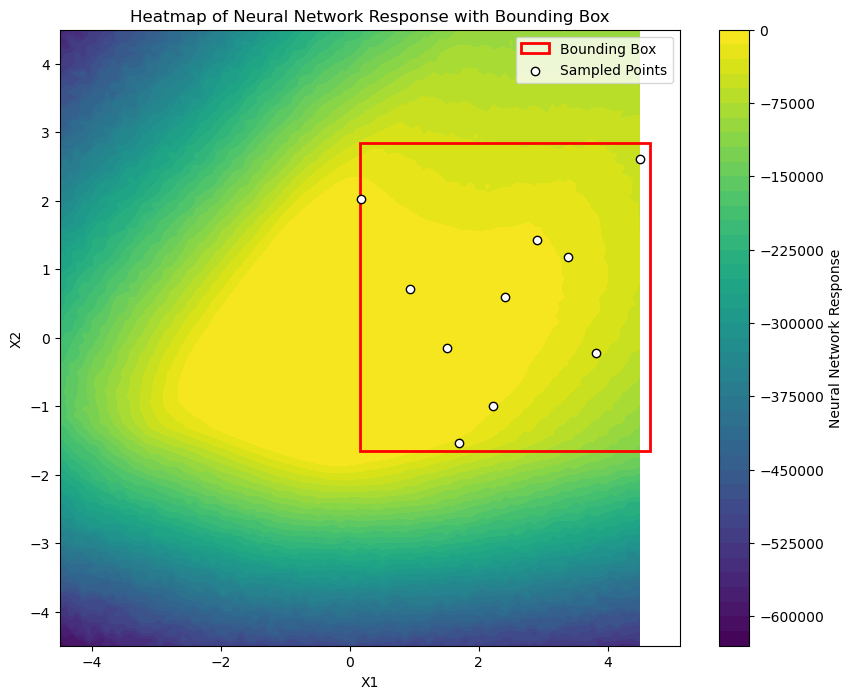

In [80]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 154729984.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 154711264.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 154627552.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 154313120.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 153607840.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 151342416.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 147888496.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 142166032.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 133090776.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 122635176.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 139561632.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 123486712.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 125648192.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

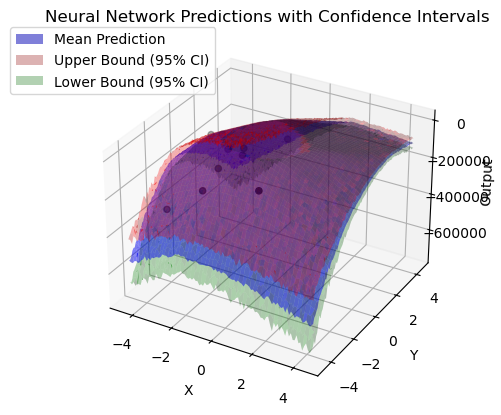

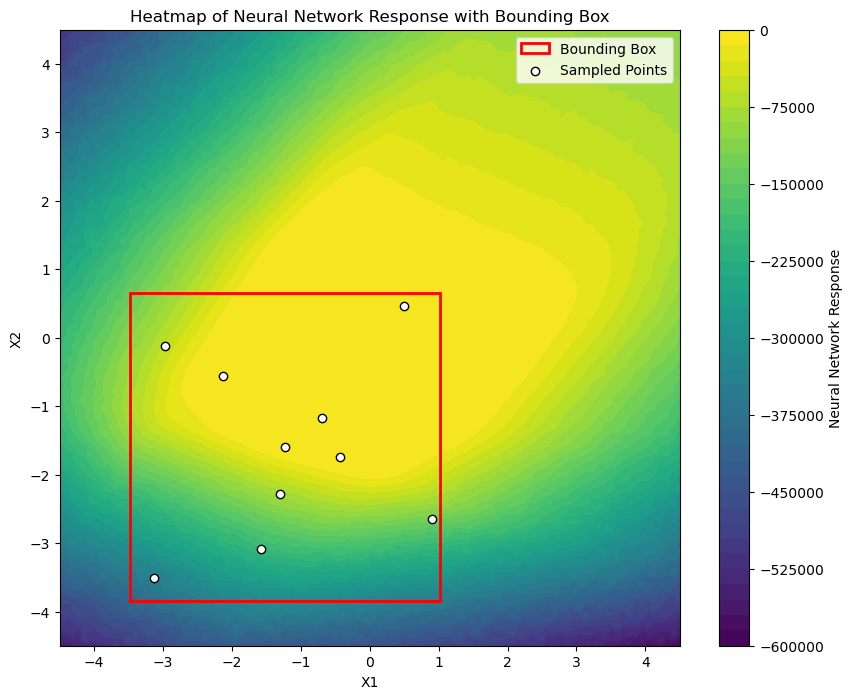

In [81]:
df_sim, df_new = perform_iteration(df_sim, df)

In [82]:
obj_val_df

Highest_Sim_Response Num_Points_In_df
0             -43.974193               15
1             -43.129637               25
2              -2.426543               35
3              -4.530786               45
4              -4.160234               55
5              -2.189780               65
6              -0.126876               75
7              -4.402201               85
8             -10.384380               95
9              -1.130900              105
10             -9.645667              115

In [83]:
obj_val_df.to_excel("BNN_response.xlsx", index=False)

In [84]:
df_new

x         y          z         a         b      sim_z      diff
8  0.498851  0.458332  -9.656484  4.323608 -2.982732  -9.645667 -0.010818
4 -0.693368 -1.179452 -32.851473  4.323608 -2.982732 -32.820424 -0.031050
6 -0.427074 -1.744323 -37.360822  4.323608 -2.982732 -37.300115 -0.060708
1 -2.134291 -0.552092 -63.297257  4.323608 -2.982732 -63.319052  0.021796
3 -2.969520 -0.126178 -81.543258  4.323608 -2.982732 -81.653605  0.110346

In [85]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

In [86]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.5171819410172759


In [87]:
df = pd.concat([df, df_new], ignore_index=True)
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
5  0.498851  0.458332    -9.656484  4.323608 -2.982732    -9.645667 -0.010818
6 -0.693368 -1.179452   -32.851473  4.323608 -2.982732   -32.820424 -0.031050
7 -0.427074 -1.744323   -37.360822  4.323608 -2.982732   -37.300115 -0.060708
8 -2.134291 -0.552092   -63.297257  4.323608 -2.982732   -63.319052  0.021796
9 -2.969520 -0.126178   -81.543258  4.323608 -2.982732   -81.653605  0.110346

In [88]:
df = df.iloc[:, :-4]
df

x         y            z
0 -0.746802 -3.668953 -1695.133401
1  1.982920 -2.823658 -2231.461373
2 -4.498971 -1.389953  -522.757847
3 -1.779007 -0.929093   -64.660164
4 -3.179197  0.349351   -70.191649
5  0.498851  0.458332    -9.656484
6 -0.693368 -1.179452   -32.851473
7 -0.427074 -1.744323   -37.360822
8 -2.134291 -0.552092   -63.297257
9 -2.969520 -0.126178   -81.543258

In [89]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 4.22173737 -3.09026523]


In [96]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  0.5, "Z": benchmark( 3,  0.5)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X    Y    Z
0  3  0.5 -0.0

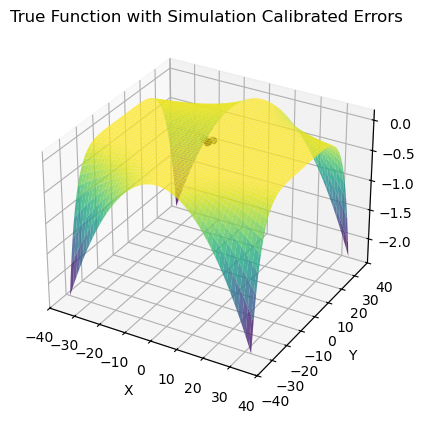

In [97]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [98]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.221737 -3.090265 -1695.083403 -0.049998
1  1.982920 -2.823658 -2231.461373  4.221737 -3.090265 -2231.633256  0.171883
2 -4.498971 -1.389953  -522.757847  4.221737 -3.090265  -522.480284 -0.277562
3 -1.779007 -0.929093   -64.660164  4.221737 -3.090265   -64.445391 -0.214773
4 -3.179197  0.349351   -70.191649  4.221737 -3.090265   -70.252802  0.061153
5  0.498851  0.458332    -9.656484  4.221737 -3.090265    -9.656962  0.000477
6 -0.693368 -1.179452   -32.851473  4.221737 -3.090265   -32.785740 -0.065733
7 -0.427074 -1.744323   -37.360822  4.221737 -3.090265   -37.285592 -0.075231
8 -2.134291 -0.552092   -63.297257  4.221737 -3.090265   -63.215818 -0.081438
9 -2.969520 -0.126178   -81.543258  4.221737 -3.090265   -81.512395 -0.030863

In [99]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.05620853617226853


In [100]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

          x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.221737 -3.090265 -1695.083403 -0.049998
1  1.982920 -2.823658 -2231.461373  4.221737 -3.090265 -2231.633256  0.171883
2 -4.498971 -1.389953  -522.757847  4.221737 -3.090265  -522.480284 -0.277562
3 -1.779007 -0.929093   -64.660164  4.221737 -3.090265   -64.445391 -0.214773
4 -3.179197  0.349351   -70.191649  4.221737 -3.090265   -70.252802  0.061153


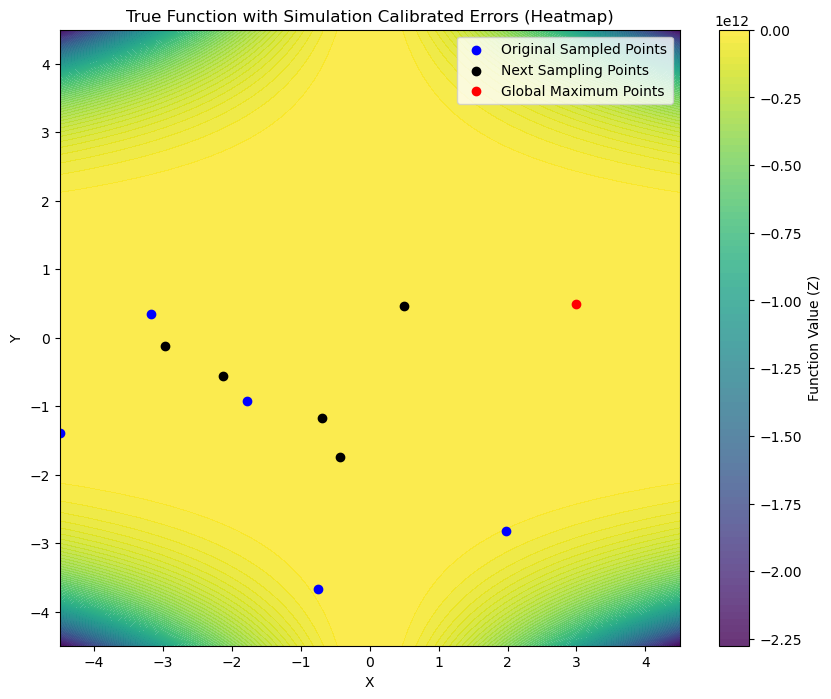

In [103]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [67]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 8
num_units: 137
learning_rate: 0.0014108892283675816
dropout_rate: 0.3793078121611787
batch_size: 34
epochs: 121
Epoch 1/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 37440.7930
Epoch 2/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 37411.9375
Epoch 3/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 37399.5078
Epoch 4/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 37367.8867
Epoch 5/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 37366.3945
Epoch 6/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 37311.2070
Epoch 7/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 37283.6445
Epoch 8/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 37156.8633
Epoch 9/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 37054.8477
Epoch 10/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 36879.9180
Epoch 11/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 36678.9102
Epoch 12/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 36149.3711
Epoch 13/121
1/1 ━━━━━━

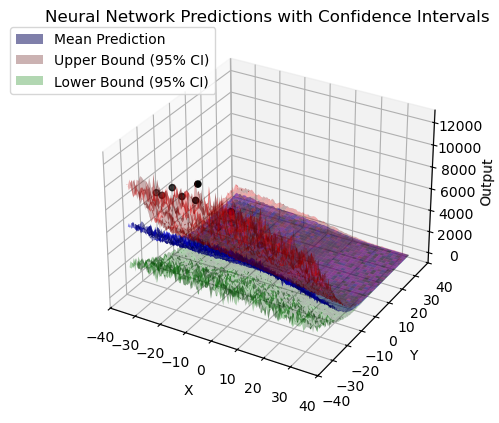

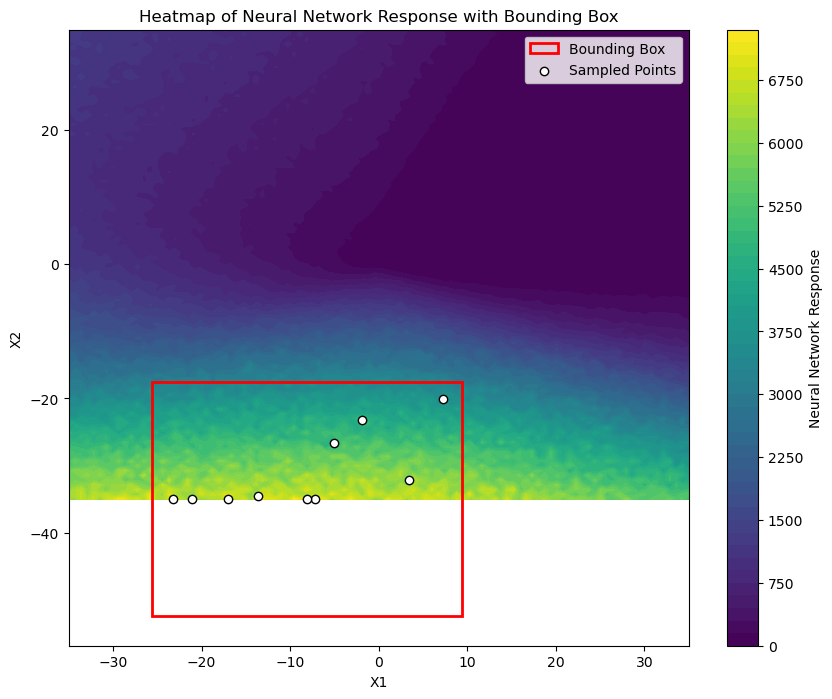

In [ ]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 162
learning_rate: 0.0007350446112476766
dropout_rate: 0.3384537308200681
batch_size: 70
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 18815.4980
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18802.4141
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 18793.2461
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18775.6094
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18776.2539
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18759.6973
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18759.0469
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18742.8340
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18743.2383
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18715.5156
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 18696.7051
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18682.9062
Epoch 13/200
1/1 ━━━━━━

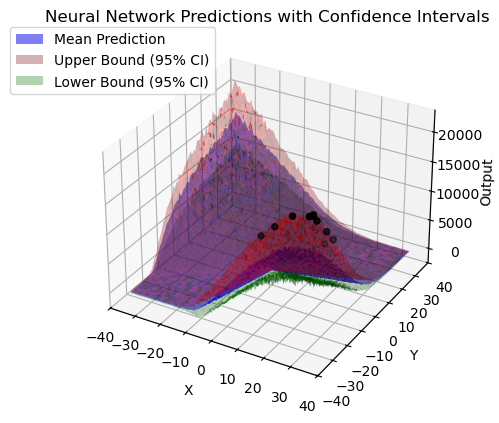

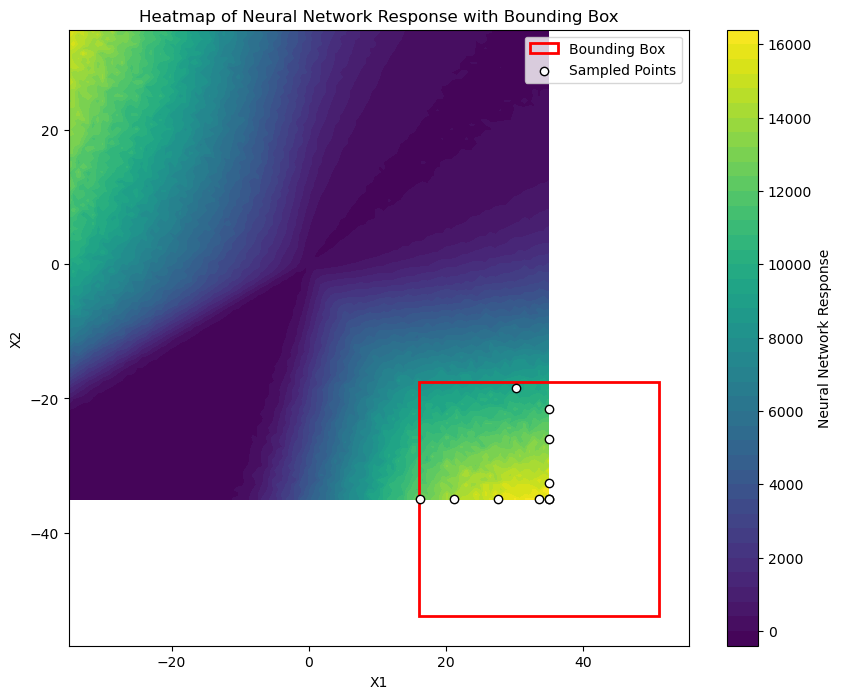

In [ ]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [ ]:
df_sim, df_new2 = perform_iteration(df_sim, df)

KeyboardInterrupt: 

Best hyperparameters:
num_layers: 8
num_units: 188
learning_rate: 0.0011756282070800373
dropout_rate: 0.2558774793979888
batch_size: 43
epochs: 153
Epoch 1/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1775.8953
Epoch 2/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1774.1877
Epoch 3/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1770.5494
Epoch 4/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1764.2317
Epoch 5/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1755.5863
Epoch 6/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1741.9856
Epoch 7/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1718.3386
Epoch 8/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1698.1791
Epoch 9/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1626.8801
Epoch 10/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1575.0958
Epoch 11/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1534.6083
Epoch 12/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1534.3031
Epoch 13/153
1/1 ━━━━━━━━━━━━━━━━━━

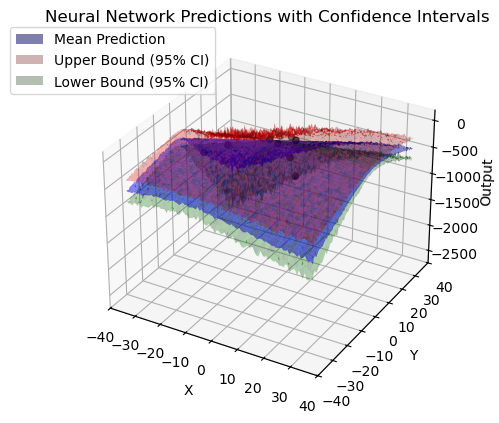

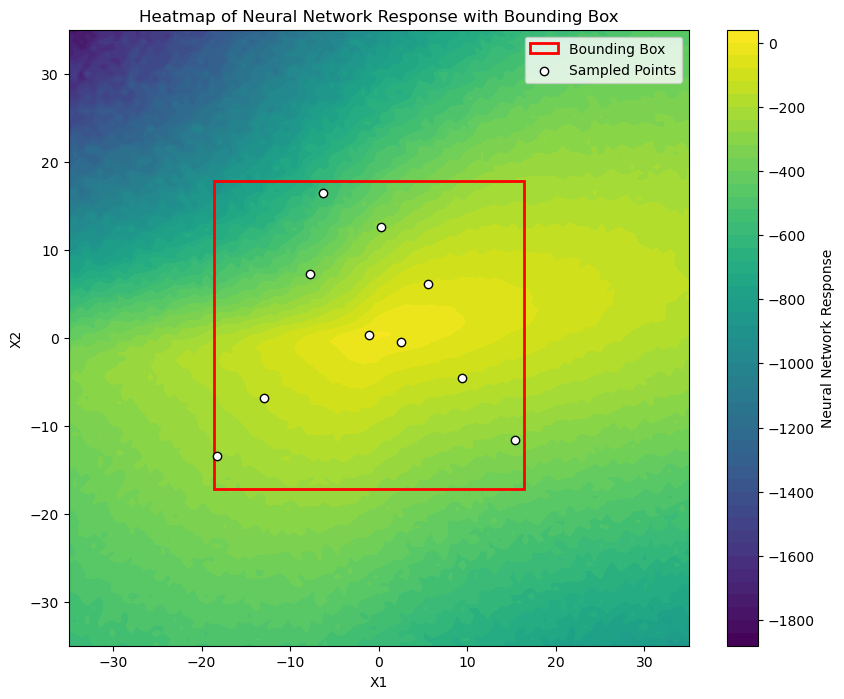

In [103]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.002127459439380763
dropout_rate: 0.35975665982909943
batch_size: 145
epochs: 88
Epoch 1/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1496.7007
Epoch 2/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1492.4194
Epoch 3/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1487.7473
Epoch 4/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1475.6921
Epoch 5/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1452.1678
Epoch 6/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1421.9442
Epoch 7/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1363.0142
Epoch 8/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1273.7080
Epoch 9/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1262.2196
Epoch 10/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1263.5988
Epoch 11/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1274.9901
Epoch 12/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1232.5935
Epoch 13/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

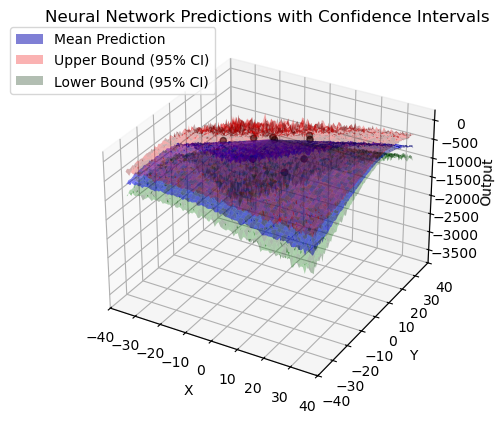

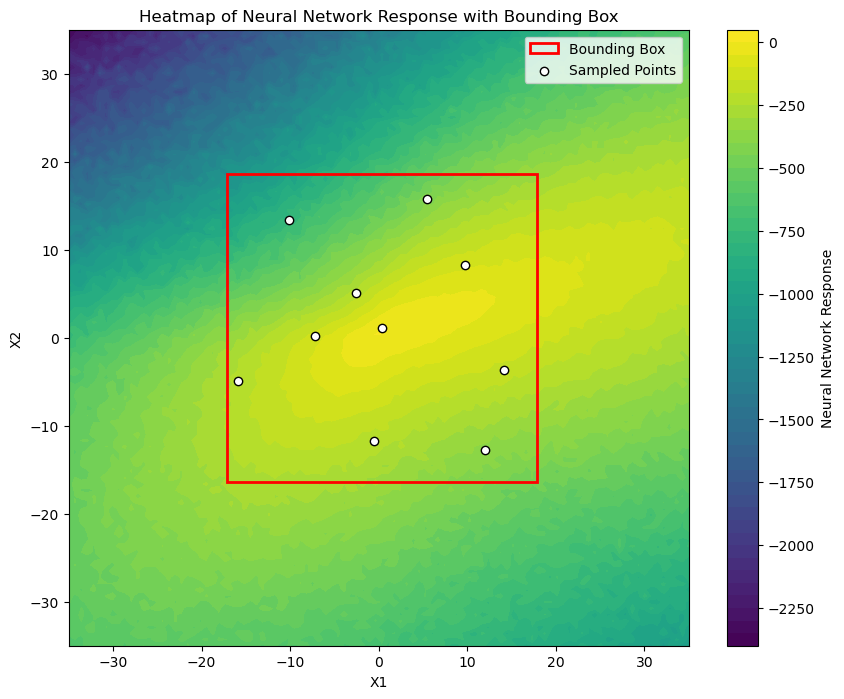

In [104]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 113
learning_rate: 0.0016774857410477234
dropout_rate: 0.12183292882148969
batch_size: 81
epochs: 112
Epoch 1/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1305.3032
Epoch 2/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1303.3003
Epoch 3/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1300.4738
Epoch 4/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1295.0715
Epoch 5/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1286.0093
Epoch 6/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1273.0836
Epoch 7/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1252.8503
Epoch 8/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1223.4102
Epoch 9/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1180.1389
Epoch 10/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1130.0618
Epoch 11/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1077.2655
Epoch 12/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1064.6096
Epoch 13/112
1/1 ━━━━━━━━━━━━━━━━━

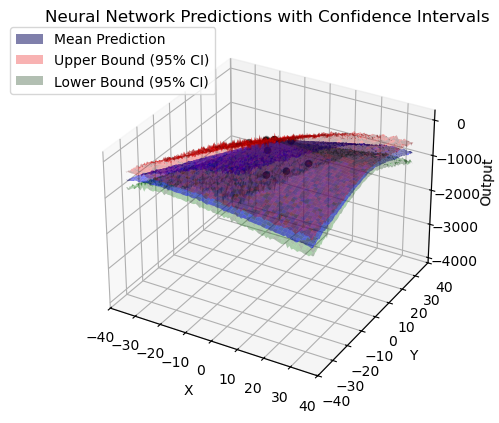

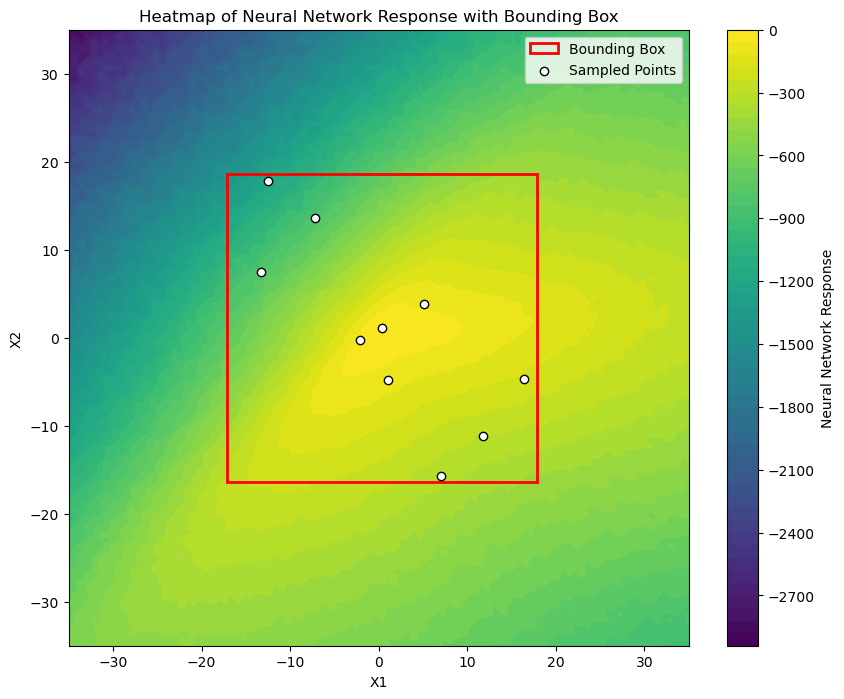

In [105]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 94
learning_rate: 0.0014164288244163672
dropout_rate: 0.10183285011643646
batch_size: 39
epochs: 187
Epoch 1/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1000.9672
Epoch 2/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1215.2811 
Epoch 3/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1050.6348
Epoch 4/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1322.1792 
Epoch 5/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1054.6564
Epoch 6/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1310.7163 
Epoch 7/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1238.3082 
Epoch 8/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 908.8893 
Epoch 9/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1200.0381 
Epoch 10/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1029.8772 
Epoch 11/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1099.7334 
Epoch 12/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 894.6170 
Epoch 13/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 

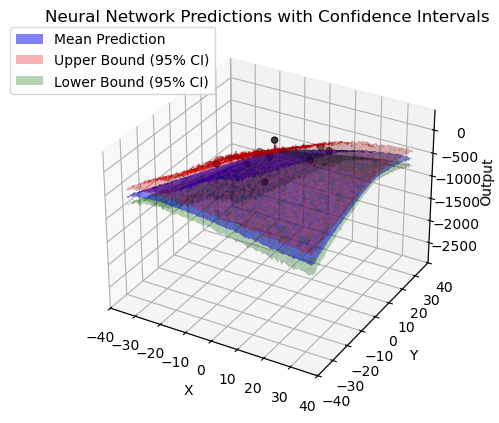

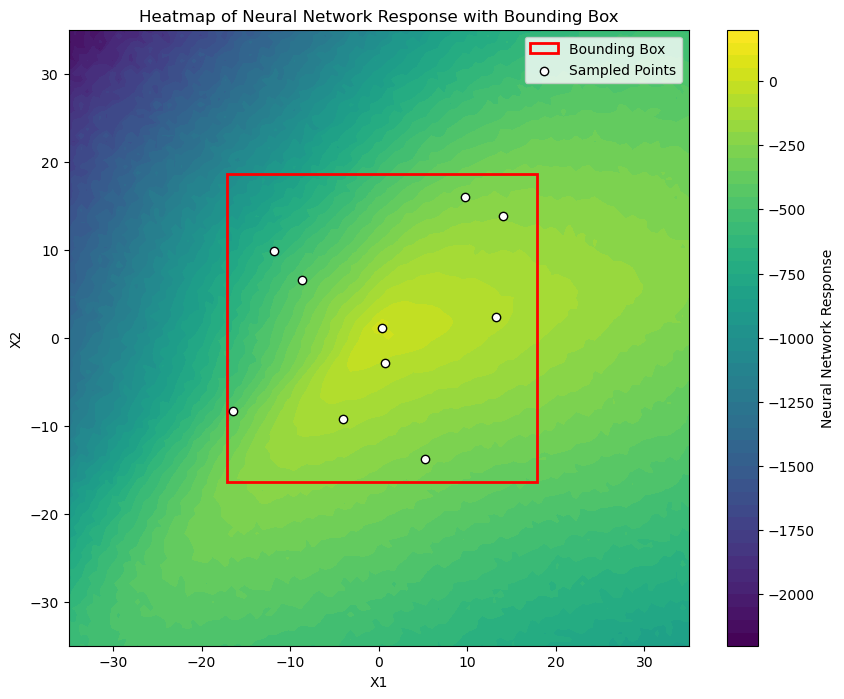

In [106]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [107]:
df_new2

x          y          z         a         b      sim_z      diff
9   0.353535   1.060606  -4.528937  4.558513 -3.308432  -4.423915 -0.105022
7   0.749010  -2.845675  -8.180547  4.558513 -3.308432  -8.320484  0.139937
3  14.004272  13.825317 -19.422100  4.558513 -3.308432 -15.737644 -3.684457
0  -4.040295  -9.269090 -16.430419  4.558513 -3.308432 -16.800240  0.369821
5  13.274854   2.299277 -18.989695  4.558513 -3.308432 -17.342310 -1.647385

In [108]:
df

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674
5  -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   -0.510053
6   3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886    2.631546
7  -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408  -16.335296
8   7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839  -21.398110
9  17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678    7.321368

In [109]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x          y          z         a         b       sim_z  \
0   23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939   
1   31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804   
2   -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515   
3    9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668   
4    5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395   
5   -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   
6    3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886   
7   -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408   
8    7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839   
9   17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678   
10   0.353535   1.060606  -4.528937  4.558513 -3.308432   -4.423915   
11   0.749010  -2.845675  -8.180547  4.558513 -3.308432   -8.320484   
12  14.004272  13.825317 -19.422100  4.558513 -3.308432  -15.737644   
13  -4.040295  -9.269090 -16.430419  4.558513 -3.308432  -16.800240   
14  13.274854   2.299277 -18.989695  4.558513 -3.308432  -17.342310   

          diff  
0   -65.051846  
1     4.010469  
2   -91.728325  
3  -190.529543  
4  -133.338674  
5    -0.510053  
6     2.631546  
7   -16.335296  
8   -21.398110  
9     7.321368  
10   -0.105022  
11    0.139937  
12   -3.684457  
13    0.369821  
14   -1.647385

In [110]:
df = df.iloc[:, :-4]
df

x          y          z
0   23.543825  11.618400 -21.792907
1   31.442859  -7.073008 -21.554335
2   -4.794645  12.618852 -18.978809
3    9.034730  18.506400 -20.764875
4    5.999539  15.517246 -19.723279
5   -0.353535  -0.353535  -3.651918
6    3.848584  -0.984131  -9.145339
7   -1.455913   5.240717 -12.707889
8    7.210342  -7.168751 -16.383271
9   17.057663  -3.899303 -18.589309
10   0.353535   1.060606  -4.528937
11   0.749010  -2.845675  -8.180547
12  14.004272  13.825317 -19.422100
13  -4.040295  -9.269090 -16.430419
14  13.274854   2.299277 -18.989695

In [111]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.51043824 -3.31352674]


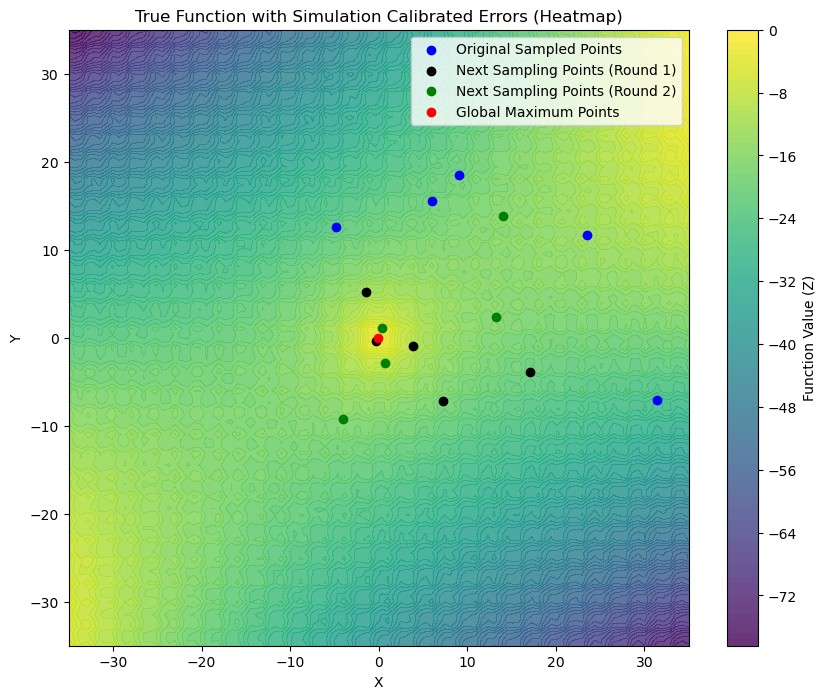

In [112]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [113]:
df_original

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674

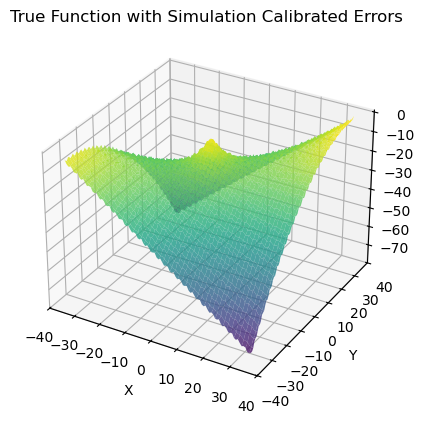

In [114]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()